### Research Paper Referred Link:
##### Environmental Sound Classification With Low-Complexity Convolutional Neural Network Empowered by Sparse Salient Region Pooling (https://ieeexplore.ieee.org/document/10002350)

# Importing Libraries

In [1]:
import math
import librosa
import os
import numpy as np
import tensorflow as tf
from scipy.special import binom
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from keras import layers, optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# File Paths
input_dir='./Datasets/ESC-10/'
# For model, kindly check the Model Training Function

# Functions for Preprocessing

In [3]:

def preprocess_audio_files(root_dir, sr=44100, n_mels=40, n_fft=1024, hop_length=256, duration=5):
    """
    Description: Preprocess audio files in a given root directory.
    Arguments:
        root_dir (str): Root directory containing the audio files.
        sr (int): Sampling rate of the audio. Default is 44100.
        n_mels (int): Number of mel frequency bins. Default is 40.
        n_fft (int): Length of the FFT window. Default is 1024.
        hop_length (int): Number of samples between successive frames. Default is 256.
        duration (int): Duration of audio segments in seconds. Default is 5.
    Returns:
        data (np.ndarray): Preprocessed mel spectrogram data.
        labels (np.ndarray): Labels corresponding to the audio files.
    """
    data = []
    labels = []
    label_map = {}
    label_idx = 0
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            filepath = os.path.join(subdir, file)
            if filepath.endswith(".ogg"):
                label = os.path.basename(subdir)
                if label not in label_map:
                    label_map[label] = label_idx
                    label_idx += 1
                label_id = label_map[label]
                labels.append(label_id)
                audio_data, _ = librosa.load(filepath, sr=sr, duration=duration)
                mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                log_mel_spec = librosa.power_to_db(mel_spec)
                if log_mel_spec.shape[1] < 862:
                    log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, 862 - log_mel_spec.shape[1])), mode='constant', constant_values=0)
                log_mel_spec = np.expand_dims(log_mel_spec, axis=-1)
                data.append(log_mel_spec)
    data = np.asarray(data)
    labels = np.asarray(labels)
    labels = to_categorical(labels, num_classes=len(label_map))
    return data, labels

def preprocess_audio_file(file_path, sr=44100, n_mels=40, n_fft=1024, hop_length=256, duration=5):
    """
    Description: Preprocess a single audio file.
    Arguments:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate of the audio. Default is 44100.
        n_mels (int): Number of mel frequency bins. Default is 40.
        n_fft (int): Length of the FFT window. Default is 1024.
        hop_length (int): Number of samples between successive frames. Default is 256.
        duration (int): Duration of audio segments in seconds. Default is 5.
    Returns:
        log_mel_spec (np.ndarray): Preprocessed log mel spectrogram of the audio file.
    """
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    y=librosa.util.normalize(y)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    if log_mel_spec.shape[1] < 862:
        log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, 862 - log_mel_spec.shape[1])), mode='constant', constant_values=0)
    log_mel_spec = np.expand_dims(log_mel_spec, axis=-1)
    log_mel_spec = np.expand_dims(log_mel_spec, axis=0)
    log_mel_spec = tf.image.resize(log_mel_spec, [40, 862])
    return log_mel_spec

# Functions for Model Creation

In [4]:
# Define the Salient Sound Region Pooling (SSRP) layer
class SSRPLayer(layers.Layer):
    def __init__(self, tau=0.5, **kwargs):
        """
        Description: Salient Sound Region Pooling (SSRP) layer.
        Arguments:
            tau (float): Threshold value for determining salient sound regions. Default is 0.5.
        Returns:
            output (Tensor): The pooled feature representation obtained from the SSRP layer.
        """
        self.tau = tau
        super(SSRPLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        Description: Build the SSRP layer.
        Arguments:
            input_shape (tuple): Shape of the input tensor.
        Returns:
            None
        """
        self.alpha = self.add_weight(name='alpha', shape=(input_shape[-1],), 
                                      initializer='ones', trainable=True)
        super(SSRPLayer, self).build(input_shape)

    def call(self, x):
        """
        Description: Perform the forward pass of the SSRP layer.
        Arguments:
            x (Tensor): Input tensor.
        Returns:
            output (Tensor): The pooled feature representation obtained from the SSRP layer.
        """
        # Compute the mean of each feature map along the time axis
        mean = tf.reduce_mean(x, axis=1, keepdims=True)

        # Compute the standard deviation of each feature map along the time axis
        std = tf.sqrt(tf.reduce_mean(tf.square(x - mean), axis=1, keepdims=True))

        # Compute the score for each feature map
        score = tf.nn.relu(self.alpha * std - self.tau)

        # Apply the score to the feature maps using element-wise multiplication
        output = x * score

        # Sum the resulting feature maps along the time axis
        output = tf.reduce_sum(output, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        """
        Description: Compute the output shape of the SSRP layer.
        Arguments:
            input_shape (tuple): Shape of the input tensor.
        Returns:
            output_shape (tuple): Shape of the output tensor.
        """
        return (input_shape[0], input_shape[-1])

def get_model(input_shape, num_classes, tau=0.5, learning_rate=0.1, momentum=0.9, dropout_rate=0.5):
    """
    Description: Create a CNN model with the Salient Sound Region Pooling (SSRP) layer.
    Arguments:
        input_shape (tuple): Shape of the input tensor.
        num_classes (int): Number of output classes. Default is 10.
        tau (float): Threshold value for determining salient sound regions in the SSRP layer. Default is 0.5.
        learning_rate (float): Learning rate for the optimizer. Default is 0.1.
        momentum (float): Momentum for the optimizer. Default is 0.9.
        dropout_rate (float): Dropout rate for the dense section. Default is 0.5.
    Returns:
        model (tf.keras.models.Model): The CNN model with the SSRP layer.
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Salient Sound Region Pooling (SSRP) layer
    x = SSRPLayer(tau=tau)(x)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs)

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model
def train_and_evaluate(X, y, num_folds=5, batch_size=32, learning_rate=0.01, momentum=0.9, num_epochs=50):
    """
    Description: Train and evaluate a model using k-fold cross-validation.
    Arguments:
        X (np.ndarray): Input data.
        y (np.ndarray): Target labels.
        num_folds (int): Number of folds for cross-validation. Default is 5.
        batch_size (int): Batch size for training. Default is 64.
        learning_rate (float): Learning rate for the optimizer. Default is 0.01.
        momentum (float): Momentum for the optimizer. Default is 0.9.
        num_epochs (int): Number of epochs for training. Default is 50.
    Returns:
        None
    """
    # kf = KFold(n_splits=num_folds, shuffle=True)
    # fold = 0
    # for train_index, test_index in kf.split(X):
        # fold += 1
        # print('Fold', fold)
        # X_train, y_train = X[train_index], y[train_index]
        # X_test,y_test = X[test_index], y[test_index]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = get_model(X_train.shape[1:], y_train.shape[1])
    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    # checkpoint_path = f'./Models/SSRP_Model_Fold{fold}.h5'
    checkpoint_path = f'./Models/SSRP_Model.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True)
    callbacks = [checkpoint]
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2, callbacks=callbacks)

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
            
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)

# Train Predict Pipeline Functions

In [5]:
def pipeline_train():
    """
    Description: Perform the training pipeline.
    Arguments:
        None
    Returns:
        None
    """
    X,y=preprocess_audio_files(input_dir)
    train_and_evaluate(X,y)

In [6]:
def pipeline_predict(filepath, model_weights_path, classes):
    """
    Description: Perform prediction on an audio file using a trained model.
    Arguments:
        filepath (str): Path to the audio file.
        model_weights_path (str): Path to the saved model weights.
        classes (list): List of class labels.
    Returns:
        predicted_class_label (str): Predicted class label of the audio file.
    """
    custom_objects = {"SSRPLayer": SSRPLayer}

    preprocessed_audio = preprocess_audio_file(filepath)
    model = load_model(model_weights_path,custom_objects=custom_objects)
    predicted_probabilities = model.predict(preprocessed_audio)
    predicted_class_index = np.argmax(predicted_probabilities)
    predicted_class_label = classes[predicted_class_index]
    
    return predicted_class_label

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 3.3043 - accuracy: 0.1562
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 8s 948ms/step - loss: 3.3043 - accuracy: 0.1562 - val_loss: 6487.5522 - val_accuracy: 0.1250
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.8713 - accuracy: 0.3164
Epoch 2: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 883ms/step - loss: 1.8713 - accuracy: 0.3164 - val_loss: 3596.3953 - val_accuracy: 0.1250
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.5816 - accuracy: 0.4492
Epoch 3: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 903ms/step - loss: 1.5816 - accuracy: 0.4492 - val_loss: 946.0330 - val_accuracy: 0.1250
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 1.4242 - accuracy: 0.4961
Epoch 4: val_accuracy did not improve from 

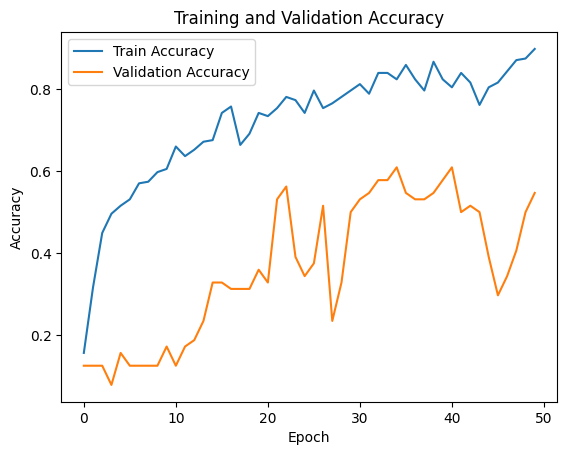

3/3 [==============================] - 1s 176ms/step - loss: 2.3931 - accuracy: 0.6000
Test loss: 2.3930516242980957
Test accuracy: 0.6000000238418579
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 3.8691 - accuracy: 0.1250
Epoch 1: val_accuracy improved from -inf to 0.15625, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 8s 914ms/step - loss: 3.8691 - accuracy: 0.1250 - val_loss: 10491.5332 - val_accuracy: 0.1562
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.0509 - accuracy: 0.3242
Epoch 2: val_accuracy improved from 0.15625 to 0.17188, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 7s 886ms/step - loss: 2.0509 - accuracy: 0.3242 - val_loss: 6395.4019 - val_accuracy: 0.1719
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 2.1634 - accuracy: 0.3789
Epoch 3: val_accuracy did not improve from 0.17188
8/8 [==============================] - 7s 860ms/step - loss: 2.1634 - 

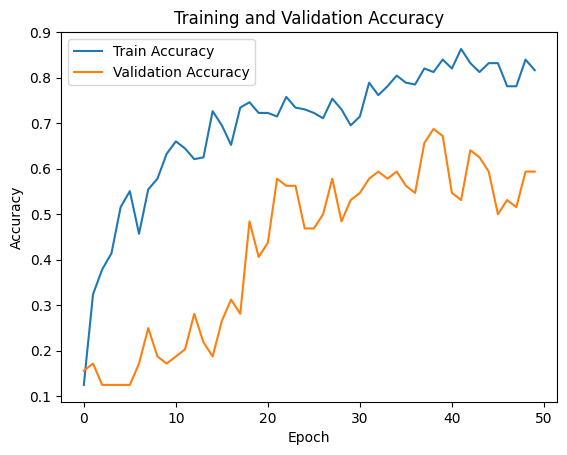

3/3 [==============================] - 1s 158ms/step - loss: 3.0744 - accuracy: 0.6125
Test loss: 3.0744194984436035
Test accuracy: 0.612500011920929
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 3.5945 - accuracy: 0.1562
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 8s 905ms/step - loss: 3.5945 - accuracy: 0.1562 - val_loss: 14765.3398 - val_accuracy: 0.1250
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.0000 - accuracy: 0.2773
Epoch 2: val_accuracy improved from 0.12500 to 0.14062, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 7s 826ms/step - loss: 2.0000 - accuracy: 0.2773 - val_loss: 3041.8728 - val_accuracy: 0.1406
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.7814 - accuracy: 0.3945
Epoch 3: val_accuracy did not improve from 0.14062
8/8 [==============================] - 7s 831ms/step - loss: 1.7814 - a

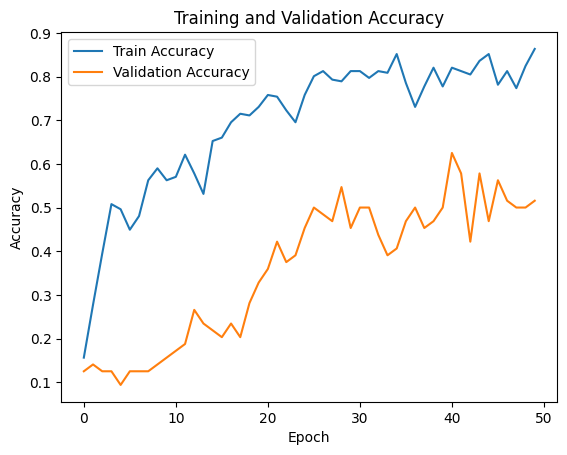

3/3 [==============================] - 1s 188ms/step - loss: 1.8967 - accuracy: 0.5375
Test loss: 1.89668869972229
Test accuracy: 0.5375000238418579
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 3.5433 - accuracy: 0.2188
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 7s 869ms/step - loss: 3.5433 - accuracy: 0.2188 - val_loss: 7667.7271 - val_accuracy: 0.1250
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.2401 - accuracy: 0.2578
Epoch 2: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 884ms/step - loss: 2.2401 - accuracy: 0.2578 - val_loss: 5139.9365 - val_accuracy: 0.0781
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 2.1837 - accuracy: 0.2656
Epoch 3: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 901ms/step - loss: 2.1837 - accuracy: 0.2656 - val_loss: 1171.8928 - val_ac

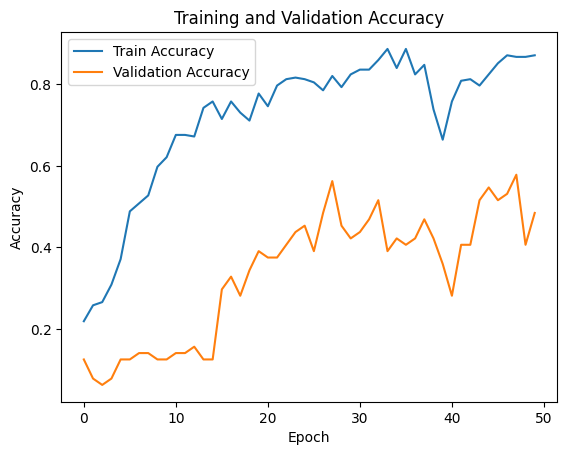

3/3 [==============================] - 1s 168ms/step - loss: 7.2602 - accuracy: 0.4500
Test loss: 7.2602410316467285
Test accuracy: 0.44999998807907104
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 3.6981 - accuracy: 0.1992
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 8s 929ms/step - loss: 3.6981 - accuracy: 0.1992 - val_loss: 24873.7695 - val_accuracy: 0.1250
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.2427 - accuracy: 0.2773
Epoch 2: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 896ms/step - loss: 2.2427 - accuracy: 0.2773 - val_loss: 10178.4766 - val_accuracy: 0.1250
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.8744 - accuracy: 0.4219
Epoch 3: val_accuracy did not improve from 0.12500
8/8 [==============================] - 8s 994ms/step - loss: 1.8744 - accuracy: 0.4219 - val_loss: 4671.5298 - v

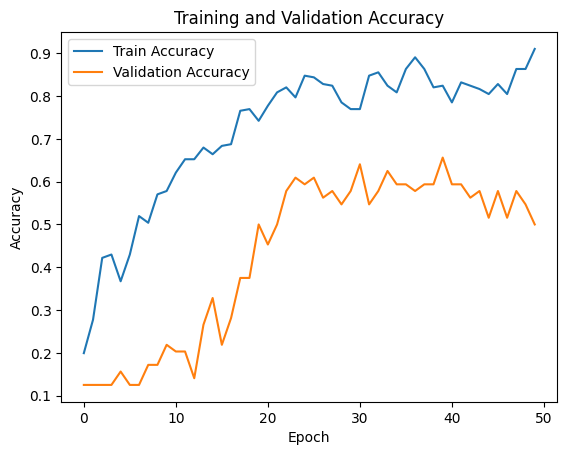

3/3 [==============================] - 1s 183ms/step - loss: 2.4741 - accuracy: 0.4750
Test loss: 2.4740569591522217
Test accuracy: 0.4749999940395355
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 4.0320 - accuracy: 0.2188
Epoch 1: val_accuracy improved from -inf to 0.07812, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 8s 906ms/step - loss: 4.0320 - accuracy: 0.2188 - val_loss: 3224.3970 - val_accuracy: 0.0781
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.2207 - accuracy: 0.2617
Epoch 2: val_accuracy improved from 0.07812 to 0.14062, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 7s 898ms/step - loss: 2.2207 - accuracy: 0.2617 - val_loss: 2695.6504 - val_accuracy: 0.1406
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 2.1803 - accuracy: 0.3008
Epoch 3: val_accuracy did not improve from 0.14062
8/8 [==============================] - 7s 860ms/step - loss: 2.1803 - a

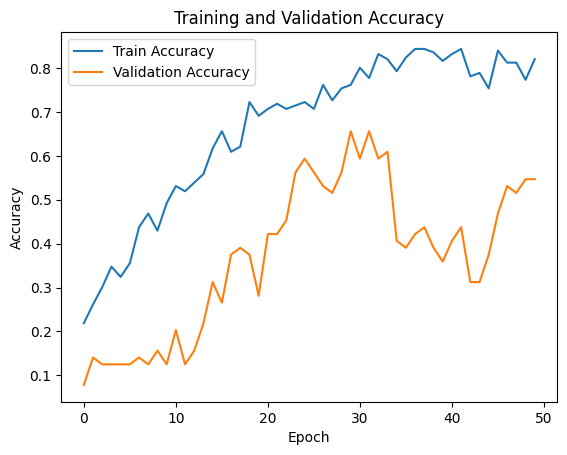

3/3 [==============================] - 1s 184ms/step - loss: 1.4935 - accuracy: 0.4625
Test loss: 1.4934659004211426
Test accuracy: 0.4625000059604645
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 3.3423 - accuracy: 0.1797
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ./Models\SSRP_Model.h5
8/8 [==============================] - 8s 909ms/step - loss: 3.3423 - accuracy: 0.1797 - val_loss: 2534.5620 - val_accuracy: 0.1250
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.1016 - accuracy: 0.3242
Epoch 2: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 924ms/step - loss: 2.1016 - accuracy: 0.3242 - val_loss: 2819.9246 - val_accuracy: 0.1250
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.8452 - accuracy: 0.4375
Epoch 3: val_accuracy did not improve from 0.12500
8/8 [==============================] - 7s 881ms/step - loss: 1.8452 - accuracy: 0.4375 - val_loss: 1691.7471 - val_

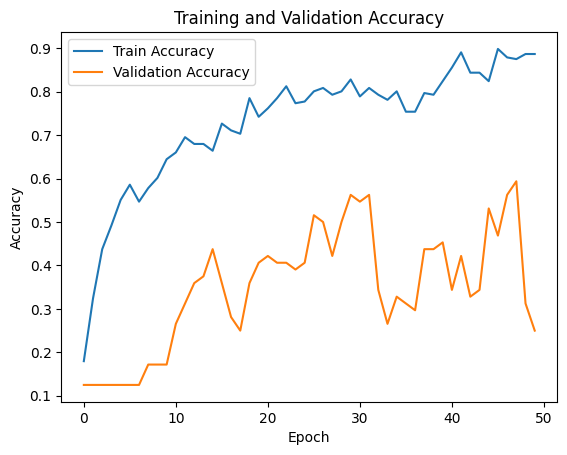

3/3 [==============================] - 1s 187ms/step - loss: 21.2135 - accuracy: 0.2000
Test loss: 21.21348762512207
Test accuracy: 0.20000000298023224
5min 58s ± 6.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit -n 1 pipeline_train()